# Анализ лояльности пользователей Яндекс Афиши

- Автор: Годзула А.И.
- Дата: 15.12.2025

# Описание данных

<font color='#777778'>Здесь приведите описание данных.</font>

Выгрузка из базы данных SQL позволила собрать следующие данные:

`user_id` — уникальный идентификатор пользователя, совершившего заказ;

`device_type_canonical` — тип устройства, с которого был оформлен заказ ( `mobile` — мобильные устройства, `desktop` — стационарные);

`order_id` — уникальный идентификатор заказа;

`order_dt` — дата создания заказа (использовались данные `created_dt_msk` );

`order_ts` — дата и время создания заказа (использовались данные `created_ts_msk` );

`currency_code` — валюта оплаты;

`revenue` — выручка от заказа;

`tickets_count` — количество купленных билетов;

`days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;

`event_id` — уникальный идентификатор мероприятия;

`service_name` — название билетного оператора;

`event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);

`region_name` — название региона, в котором прошло мероприятие;

`city_name` — название города, в котором прошло мероприятие.

# Содержимое проекта

Шаг 1. Загрузка данных и их предобработка

Шаг 2. Предобработка данных

Шаг 3. Создание профиля пользователя

Шаг 4. Исследовательский анализ данных

Шаг 5. Общие выводы и рекомендации

# Цели и задачи проекта
Команда маркетинга хочет лучше понимать поведение пользователей. 

Для этого требуется провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

Это позволит:

- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.

- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.

- Оптимизировать маркетинговые бюджеты.

- Повысить общий уровень удержания клиентов.

## Загрузка данных и знакомство с ними

In [1]:
#Устанавливаем необходимые библиотеки при необходимости
!pip install sqlalchemy
!pip install psycopg2-binary
!pip install phik

In [2]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеку для подключения к СУБД
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

import os
from dotenv import load_dotenv

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

db_config = {
    'host': os.getenv('DB_HOST'),
    'port': int(os.getenv('DB_PORT')),
    'db': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD')
}

# Пишем настройки неоходимые для подключения к СУБД
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [4]:
# Создаем строку для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

In [6]:
# Пишем SQL запрос для выгузки датасета
query = '''
SELECT  user_id,
        device_type_canonical,
        order_id,
        created_dt_msk,
        created_ts_msk,
        currency_code,
        revenue,
        tickets_count,
        EXTRACT(day FROM (created_dt_msk - (LAG(created_dt_msk) over (partition by user_id order by created_dt_msk)))) as days_since_prev,
        p.event_id,
        e.event_name_code as event_name,
        event_type_main,
        service_name,
        region_name,
        city_name
FROM afisha.purchases p
JOIN afisha.events e ON p.event_id=e.event_id
JOIN afisha.city c ON e.city_id=c.city_id
JOIN afisha.regions r ON c.region_id=r.region_id
WHERE (device_type_canonical = 'mobile' or device_type_canonical = 'desktop') and event_type_main != 'фильм'
ORDER BY user_id
'''

In [7]:
# Сохраняем датасет в переменнуб df
df = pd.read_sql_query(query, con=engine)

In [8]:
df.shape

(290611, 15)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [10]:
display(df.head())

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

### Промежуточный вывод

Сделайте промежуточный вывод о полученных данных: данные какого объёма вам предоставили, соответствуют ли данные описанию, встречаются ли в них пропуски, используются ли верные типы данных. Отметьте другие особенности данных, которые вы обнаружите на этой стадии и на которые стоит обратить внимание при предобработке.

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Выгруженный из СУБД датасет содержит 290611 строк и 15 колонок, занимает 33.3+ MB. Пропуски обнаружены только в колонке `days_since_prev` (21933 шт.) как и предполагалось на этапе подготовки SQL запроса. Названия колонок уже приведено к `snake_case`. 

Типы данных распознаны корректно: datetime64[ns](2 колонки), float64(2 колонки), int64(3 колонки), object(8 колонок).

Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

## Предобработка данных

### Задача 2.1. 
- Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Добавляю информацию из датасета `final_tickets_tenge_df.csv` по ссылке `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv`

In [11]:
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
display(df_tenge)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [13]:
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [14]:
# Преобразуем столбец data из датафрейка курса валюты в тип datetime64[ns]
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

In [15]:
# Объединяем два датафрейма для дальнейшего преобразования в рубли столбца revenue
df_merged = df.merge(
    df_tenge,
    left_on= 'created_dt_msk',
    right_on= ['data'],
    how='left'
)
df_merged

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск,2024-10-27,100,19.9266,kzt
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск,2024-10-27,100,19.9266,kzt
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск,2024-10-30,100,19.9516,kzt
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка,2024-09-24,100,19.3967,kzt


In [16]:
# Корректуруем значения в столбце revenue
for index, row in df_merged.iterrows():
    if row['currency_code'] == 'kzt':
        # Изменяем конкретную ячейку по индексу
        df_merged.at[index, 'revenue'] = round((row['revenue'] * row['curs'] / 100),2)
        df_merged.at[index, 'currency_code'] = 'rub'


In [17]:
df_rub = df_merged[['user_id',
                    'device_type_canonical',
                    'order_id','created_dt_msk',
                    'created_ts_msk',
                    'currency_code',
                    'revenue',
                    'tickets_count',
                    'days_since_prev',
                    'event_id',
                    'event_name',
                    'event_type_main',
                    'service_name',
                    'region_name',
                    'city_name']].copy()
display(df_rub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Произвели преобразование выручки к единой валюте — российскому рублю.

### Задача 2.2.
- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
- Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
- Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха. Важные показатели в рамках поставленной задачи — это выручка с заказа ( `revenue_rub` ) и количество билетов в заказе ( `tickets_count` ), поэтому в первую очередь проверьте данные в этих столбцах. Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.
- После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

In [18]:
#Выполняем оптимизацию столбца chain
df_rub['revenue'] = pd.to_numeric(df_rub['revenue'], downcast='float')
df_rub['tickets_count'] = pd.to_numeric(df_rub['tickets_count'], downcast='integer')
df_rub['days_since_prev'] = pd.to_numeric(df_rub['days_since_prev'], downcast='float')

In [19]:
df_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [20]:
def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    #Сортировка по количеству пропусков
    missing_stats = missing_stats.sort_values('Кол-во пропусков', ascending=True)
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))
show_missing_stats(df_rub)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


In [21]:
#Выводим ункальные значение
for column in df_rub.columns:
    print(f'Уникальные значения в {column}:')
    display(df_rub[column].unique())
    print(f'Количество уникальных значений в {column}:')
    display(df_rub[column].nunique())

Уникальные значения в user_id:


array(['0002849b70a3ce2', '0005ca5e93f2cf4', '000898990054619', ...,
       'fffcd3dde79eb2c', 'fffeeb3c120cf0b', 'ffff00725179321'],
      dtype=object)

Количество уникальных значений в user_id:


21933

Уникальные значения в device_type_canonical:


array(['mobile', 'desktop'], dtype=object)

Количество уникальных значений в device_type_canonical:


2

Уникальные значения в order_id:


array([4359165, 7965605, 7292370, ..., 8473772, 5526067,  813654],
      dtype=int64)

Количество уникальных значений в order_id:


290611

Уникальные значения в created_dt_msk:


<DatetimeArray>
['2024-08-20 00:00:00', '2024-07-23 00:00:00', '2024-10-06 00:00:00',
 '2024-07-13 00:00:00', '2024-10-04 00:00:00', '2024-10-23 00:00:00',
 '2024-08-15 00:00:00', '2024-09-29 00:00:00', '2024-10-15 00:00:00',
 '2024-06-20 00:00:00',
 ...
 '2024-06-08 00:00:00', '2024-08-23 00:00:00', '2024-06-05 00:00:00',
 '2024-06-12 00:00:00', '2024-06-15 00:00:00', '2024-06-24 00:00:00',
 '2024-06-26 00:00:00', '2024-08-03 00:00:00', '2024-08-16 00:00:00',
 '2024-06-10 00:00:00']
Length: 153, dtype: datetime64[ns]

Количество уникальных значений в created_dt_msk:


153

Уникальные значения в created_ts_msk:


<DatetimeArray>
['2024-08-20 16:08:03', '2024-07-23 18:36:24', '2024-10-06 13:56:02',
 '2024-07-13 19:40:48', '2024-10-04 22:33:15', '2024-10-23 15:12:00',
 '2024-08-15 16:48:48', '2024-09-29 19:39:12', '2024-10-15 10:29:04',
 '2024-06-20 10:51:10',
 ...
 '2024-10-07 21:13:35', '2024-10-15 23:20:36', '2024-10-16 21:48:33',
 '2024-10-22 13:46:24', '2024-10-26 17:43:23', '2024-10-27 18:00:57',
 '2024-10-27 17:54:52', '2024-10-30 13:37:43', '2024-09-24 10:07:42',
 '2024-09-25 15:12:40']
Length: 280753, dtype: datetime64[ns]

Количество уникальных значений в created_ts_msk:


280753

Уникальные значения в currency_code:


array(['rub'], dtype=object)

Количество уникальных значений в currency_code:


1

Уникальные значения в revenue:


array([1521.94,  289.45, 1258.57, ...,  107.81,  543.  , 1448.36])

Количество уникальных значений в revenue:


43089

Уникальные значения в tickets_count:


array([ 4,  2,  3,  1,  5,  6, 10,  9,  7, 15, 13, 11,  8, 14, 12, 47, 27,
       17, 19, 57, 30, 37], dtype=int8)

Количество уникальных значений в tickets_count:


22

Уникальные значения в days_since_prev:


array([ nan,  75.,  83.,  19.,  16.,   0.,   1.,  74.,  13.,  25.,  30.,
        29.,  23.,  63.,  14.,  11.,   7.,   5.,  26.,  10.,  15.,   3.,
        18.,   4.,  70.,  20.,  35.,  33.,  22.,  53.,  39.,  31.,  17.,
        27.,  40.,  24.,  12.,  47.,   9.,   2.,   6.,  51.,  55.,  68.,
        52.,   8.,  71.,  28.,  46., 134.,  41.,  79.,  86.,  60.,  49.,
       122.,  32.,  78.,  80.,  38.,  37.,  85.,  88.,  43., 128.,  61.,
       108.,  21.,  50.,  81., 137.,  48.,  45.,  94.,  34.,  84., 107.,
        42.,  44.,  56.,  82., 123., 101.,  69., 115.,  97.,  36., 112.,
        65.,  99.,  67.,  91.,  95.,  57.,  77.,  58.,  73.,  59., 132.,
        93.,  72., 129.,  62., 118.,  96., 100., 105.,  54.,  76., 131.,
       104.,  92., 114., 127., 109., 121.,  66.,  64., 110., 103., 148.,
        90.,  98.,  89., 120., 139., 144., 102.,  87., 135., 116., 141.,
       111., 124., 106., 113., 145., 117., 142., 130., 126., 146., 140.,
       125., 136., 133., 147., 119., 138., 143.], d

Количество уникальных значений в days_since_prev:


149

Уникальные значения в event_id:


array([169230, 237325, 578454, ..., 300765, 540339, 568852], dtype=int64)

Количество уникальных значений в event_id:


22427

Уникальные значения в event_name:


array(['f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad',
       '40efeb04-81b7-4135-b41f-708ff00cc64c',
       '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca', ...,
       'cf71bf2b-8e5c-47e0-a0f3-c2d4910c4677',
       'f17a01b7-3cd3-4cd1-919c-3459bd074886',
       '0fd6df8e-49e5-4337-954d-5a4606b1b899'], dtype=object)

Количество уникальных значений в event_name:


15248

Уникальные значения в event_type_main:


array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Количество уникальных значений в event_type_main:


7

Уникальные значения в service_name:


array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

Количество уникальных значений в service_name:


36

Уникальные значения в region_name:


array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

Количество уникальных значений в region_name:


81

Уникальные значения в city_name:


array(['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск',
       'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай',
       'Верховино', 'Светополье', 'Кокжар', 'Каменский', 'Лесоярич',
       'Никольянов', 'Речинцево', 'Лесозолотск', 'Дальнозерск',
       'Серебрянка', 'Островецк', 'Родниковец', 'Дальнесветск',
       'Луговаярово', 'Ягодиновка', 'Дальнополин', 'Солчелуг', 'Озёрчане',
       'Серебровино', 'Лесоярово', 'Глинополье', 'Глиноград',
       'Дальнесветин', 'Северополье', 'Теплоозеро', 'Горнодолинск',
       'Ордакент', 'Озёрово', 'Луговинск', 'Лугоград', 'Златопольск',
       'Крутовинск', 'Сарыжар', 'Сосновечин', 'Тихоярск', 'Яблонецк',
       'Жаркентай', 'Широковка', 'Синеводов', 'Синеводск', 'Тихосветск',
       'Радужанов', 'Каменосветск', 'Глиногорь', 'Родниковск',
       'Травогород', 'Глинянск', 'Радужинск', 'Поляногорье',
       'Дальнолесье', 'Ручейник', 'Ключеград', 'Ключеводск', 'Поленовино',
       'Речичанск', 'Ключевополье', 'Шаныртау', 'Дальнесоснов'

Количество уникальных значений в city_name:


352

In [22]:
# Проверяем неявные дубликаты в датафрейме df
print('Количество неявных дубликатов в данных:', df_rub.duplicated().sum())

Количество неявных дубликатов в данных: 0


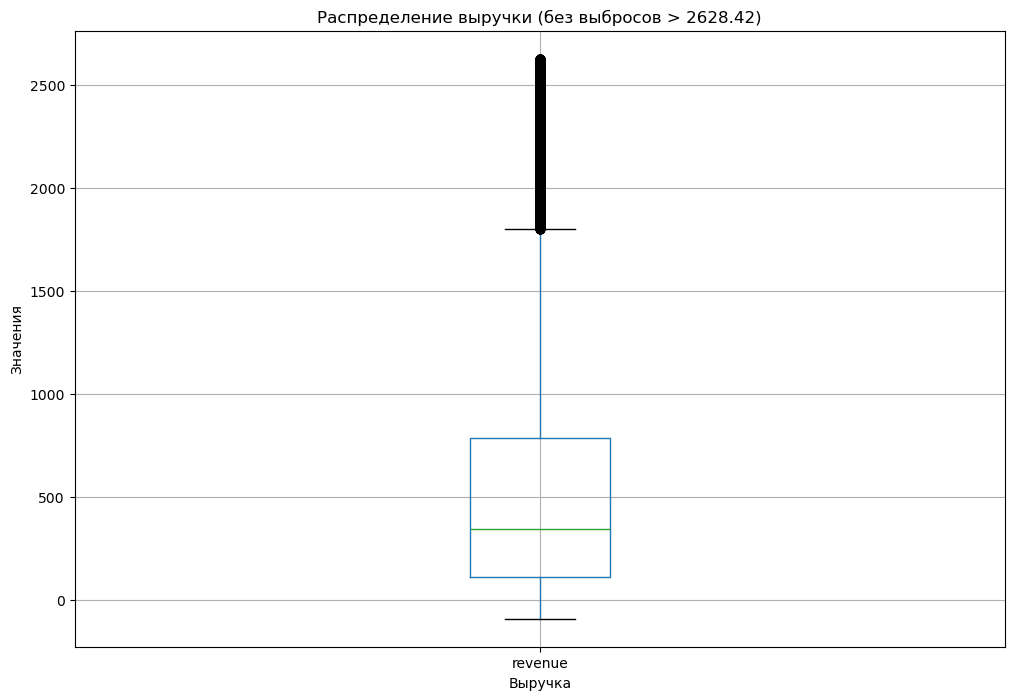

Среднее значение по выручке: 556
Медиана по выручке: 351
Было строк: 290611
Стало строк: 287604
Удалено выбросов: 3007


In [23]:
# Вычисляем 99-й перцентиль
threshold_revenue = df_rub['revenue'].quantile(0.99)

# Фильтруем строки, где выручка МЕНЬШЕ порога (оставляем 99% данных)
filtered_df_revenue = df_rub[df_rub['revenue'] < threshold_revenue]

# Строим boxplot
plt.figure(figsize=(12, 8))
filtered_df_revenue.boxplot(column='revenue')
plt.title(f'Распределение выручки (без выбросов > {threshold_revenue:.2f})')

plt.xlabel('Выручка')
plt.ylabel('Значения')
plt.show()

# Проверяем, сколько строк удалили
print(f"Среднее значение по выручке: {round(df_rub['revenue'].mean())}")
print(f"Медиана по выручке: {round(df_rub['revenue'].median())}")
print(f"Было строк: {len(df_rub)}")
print(f"Стало строк: {len(filtered_df_revenue)}")
print(f"Удалено выбросов: {len(df_rub) - len(filtered_df_revenue)}")

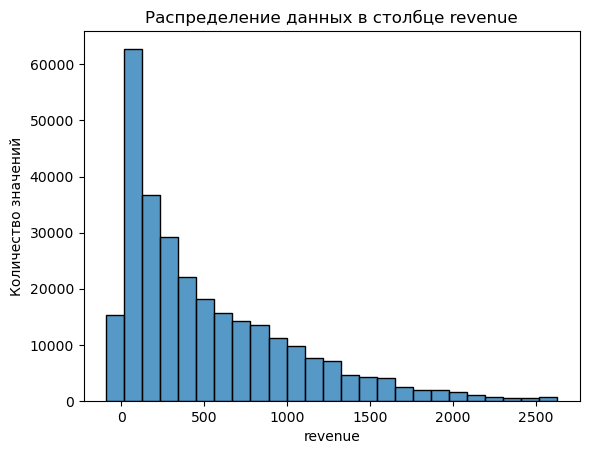

In [24]:
# Построим распределение данных для столбца `score`
sns.histplot(data=filtered_df_revenue, x='revenue', bins=25)

# Подписываем и отображаем график
plt.title('Распределение данных в столбце revenue')
plt.ylabel('Количество значений')
plt.show()

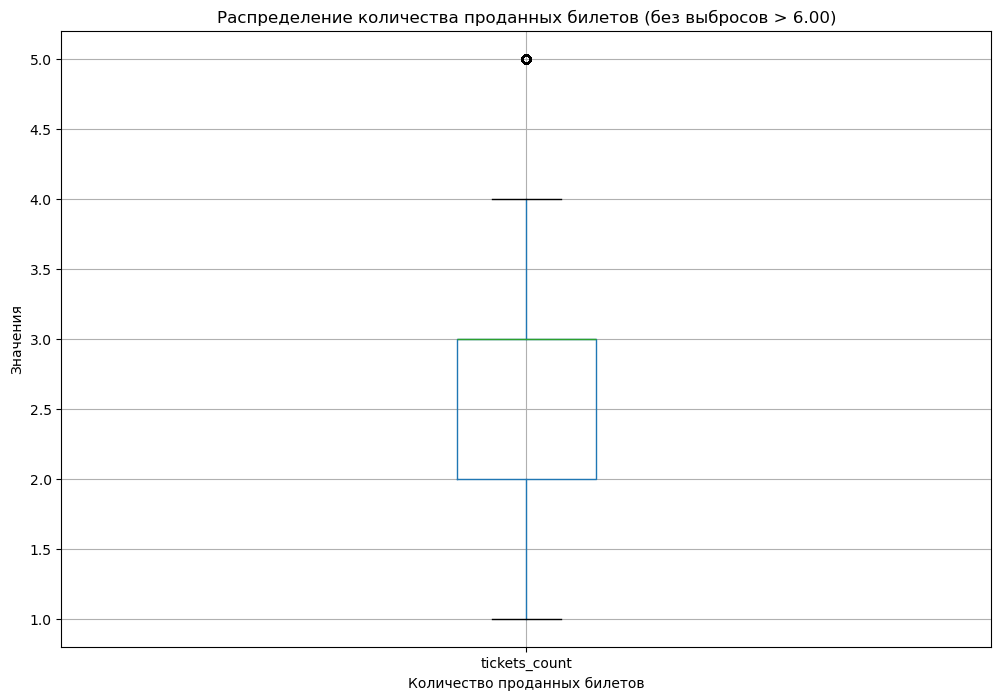

Среднее значение по количеству купленных билетов: 2.69
Медиана по количеству купленных билетов: 3.0
Было строк: 287604
Стало строк: 283479
Удалено выбросов: 4125
Удалено всего выбросов: 7132
Процент удаленых выбросов: 2.45%


In [25]:
# Вычисляем 99-й перцентиль
threshold_tickets = filtered_df_revenue['tickets_count'].quantile(0.99)

# Фильтруем строки, где выручка МЕНЬШЕ порога (оставляем 99% данных)
df = filtered_df_revenue[filtered_df_revenue['tickets_count'] < threshold_tickets]

# Строим boxplot
plt.figure(figsize=(12, 8))
df.boxplot(column='tickets_count')
plt.title(f'Распределение количества проданных билетов (без выбросов > {threshold_tickets:.2f})')
plt.xlabel('Количество проданных билетов')
plt.ylabel('Значения')
plt.show()

# Проверяем, сколько строк удалили
print(f"Среднее значение по количеству купленных билетов: {round(df['tickets_count'].mean(),2)}")
print(f"Медиана по количеству купленных билетов: {df['tickets_count'].median()}")
print(f"Было строк: {len(filtered_df_revenue)}")
print(f"Стало строк: {len(df)}")
print(f"Удалено выбросов: {len(filtered_df_revenue) - len(df)}")
print(f"Удалено всего выбросов: {len(df_rub) - len(df)}")
print(f"Процент удаленых выбросов: {round((100*(len(df_rub) - len(df))/len(df_rub)),2)}%")

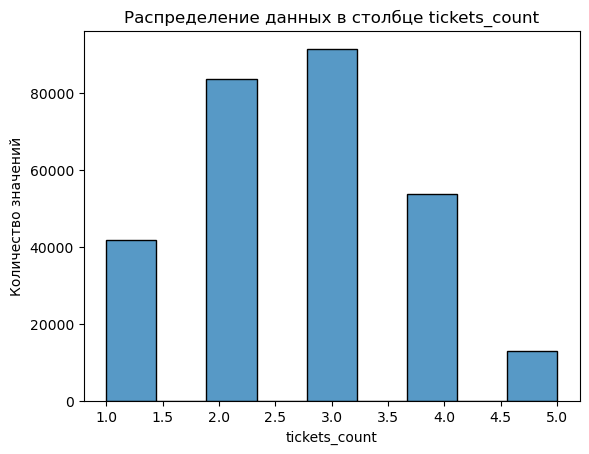

In [26]:
# Построим распределение данных для столбца `score`
sns.histplot(data=df, x='tickets_count', bins=9)

# Подписываем и отображаем график
plt.title('Распределение данных в столбце tickets_count')
plt.ylabel('Количество значений')
plt.show()

### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Пропуски в данных присутствуют только в столбце `days_since_prev` (21933 пропусков) как и предполагалось при выгрузке данных.

В процессе предобратки были сокращены размерности для трех столбцов -  `revenue`, `tickets_count`, `days_since_prev`. Для остальных столбцов преобразований не требуется, они были корректно преобразованы в датафрейм.

При ознакомлении с уникальными значениями в столбцах дубликатов, заглушек или ошибок не выявлено. Нормализация данных не требуется.

При проверке распределения значений в столбцах `revenue` и `tickets_count` были выявлены выбросы искажающие общую картину, для дальнейшего корректного анализа были удалены значения после 99 перцентиля. В результате удаления количество строк сократилось на 7132 значение, что соответсвует 2.45% от всех данных.

Можно заметить что медиана по выручке `revenue` равна 351 руб., в то время как среднее значение 556руб., значит имеется ярко выраженное смещение графика вправо в виде "хвоста". Такое же смещение можно заметить и на графиках количества проданных билетов, только "хвост" не так ярко выражен. Среднее значения для `tickets_count` равно 2.69 в то время как медиана равна 3.

Из полученных данных можно сделать вывод что чаще всего пользователи покупают 2-3 билета на сумму ~ 350 руб.

## Создание профиля пользователя
В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

### Задача 3.1. 
Постройте профиль пользователя — для каждого пользователя найдите:
- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле event_type_main );
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.
- После этого добавьте два бинарных признака:
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

`Рекомендация: перед тем как строить профиль, отсортируйте данные по времени совершения заказа.`

In [27]:
df = df.sort_values('created_ts_msk')

In [28]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'created_dt_msk',
       'created_ts_msk', 'currency_code', 'revenue', 'tickets_count',
       'days_since_prev', 'event_id', 'event_name', 'event_type_main',
       'service_name', 'region_name', 'city_name'],
      dtype='object')

In [29]:
df_profile = df.groupby('user_id').agg({'created_dt_msk': ['first','last'],
                           'device_type_canonical': 'first',
                            'region_name': 'first',
                            'service_name': 'first',
                            'event_type_main': 'first',
                            'order_id': 'nunique',
                            'revenue': 'mean',
                            'tickets_count': 'mean',
                            'days_since_prev': 'mean'
                            })

In [30]:
df_profile = df_profile.reset_index()
df_profile

user_id created_dt_msk            device_type_canonical  \
                                first       last                 first   
0      0002849b70a3ce2     2024-08-20 2024-08-20                mobile   
1      0005ca5e93f2cf4     2024-07-23 2024-10-06                mobile   
2      000898990054619     2024-07-13 2024-10-23                mobile   
3      00096d1f542ab2b     2024-08-15 2024-08-15               desktop   
4      000a55a418c128c     2024-09-29 2024-10-15                mobile   
...                ...            ...        ...                   ...   
21700  fff13b79bd47d7c     2024-07-16 2024-10-31                mobile   
21701  fff32fc9ad0f9f6     2024-08-15 2024-10-28               desktop   
21702  fffcd3dde79eb2c     2024-06-20 2024-10-30               desktop   
21703  fffeeb3c120cf0b     2024-09-24 2024-09-24               desktop   
21704  ffff00725179321     2024-09-25 2024-09-25                mobile   

                region_name        service_name event_type_main order_id  \
                      first               first           first  nunique   
0        Каменевский регион        Край билетов           театр        1   
1        Каменевский регион           Мой билет        выставки        2   
2      Североярская область         Лови билет!          другое        3   
3        Каменевский регион        Край билетов           театр        1   
4          Поленовский край       Лучшие билеты           театр        2   
...                     ...                 ...             ...      ...   
21700    Каменевский регион           Мой билет          другое        9   
21701    Каменевский регион  Билеты без проблем         стендап        2   
21702    Каменевский регион  Билеты без проблем        концерты       31   
21703   Широковская область  Билеты без проблем         стендап        1   
21704  Малиновоярский округ           Мой билет        концерты        1   

           revenue tickets_count days_since_prev  
              mean          mean            mean  
0      1521.940000      4.000000             NaN  
1       774.010000      3.000000       75.000000  
2       767.213333      2.666667       51.000000  
3       917.830000      4.000000             NaN  
4        61.310000      1.500000       16.000000  
...            ...           ...             ...  
21700   688.043333      2.555556       13.375000  
21701   850.995000      2.500000       74.000000  
21702   504.308710      2.580645        3.966667  
21703   661.530000      2.000000             NaN  
21704   802.250000      2.000000             NaN  

[21705 rows x 11 columns]

In [31]:
df_profile.columns = ['user_id',
                      'first_order_dt',
                      'last_order_dt',
                      'first_device',
                      'first_region',
                      'first_service',
                      'first_event_type',
                      'count_order',
                      'mean_revenue',
                      'mean_tickets',
                      'mean_days'
                     ]

In [32]:
# Добавляем бинарные признаки
for index, row in df_profile.iterrows():
    # Проверяем наличия двух и более заказов
    df_profile['is_two'] = (df_profile['count_order'] >= 2).astype(int)
    # Проверяем наличия пяти и более заказов
    df_profile['is_five'] = (df_profile['count_order'] >= 5).astype(int)

In [33]:
df_profile[['mean_revenue','mean_tickets','mean_days']] = round(df_profile[['mean_revenue','mean_tickets','mean_days']])
df_profile['mean_tickets'] = pd.to_numeric(df_profile['mean_tickets'], downcast='float')
df_profile['is_two'] = pd.to_numeric(df_profile['is_two'], downcast='integer')
df_profile['is_five'] = pd.to_numeric(df_profile['is_five'], downcast='integer')
df_profile['count_order'] = pd.to_numeric(df_profile['count_order'], downcast='integer')

In [34]:
df_profile

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,count_order,mean_revenue,mean_tickets,mean_days,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1522.0,4.0,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.0,3.0,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.0,3.0,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,918.0,4.0,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.0,2.0,16.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21700,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.0,3.0,13.0,1,1
21701,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,851.0,2.0,74.0,1,0
21702,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,31,504.0,3.0,4.0,1,1
21703,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,662.0,2.0,NaN,0,0


### Задача 3.2. 
Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.
Используя данные о профилях пользователей, рассчитайте:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:
- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:
- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?
- - Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
# Считаем пользователей в выборке
count_users = df_profile['user_id'].count()
print(f'Общее число пользователей в выборке: {count_users}.')

# Считаем среднюю выручку
mean_revenue = round((df_profile['mean_revenue'].sum()/ count_users),2)
print(f'Средняя выручка с одного заказа: {mean_revenue}.')

# Считаем доли пользователей совершивших 2 и более, а также 5 и более покупок
share_two = round((df_profile['is_two'].sum()/ count_users),2)
share_five = round((df_profile['is_five'].sum()/ count_users),2)
print(f'Доля пользователей, совершивших 2 и более заказа: {share_two}.')
print(f'Доля пользователей, совершивших 5 и более заказа: {share_five}.')

Общее число пользователей в выборке: 21705.
Средняя выручка с одного заказа: 538.85.
Доля пользователей, совершивших 2 и более заказа: 0.62.
Доля пользователей, совершивших 5 и более заказа: 0.29.


In [36]:
df_profile.describe()

,first_order_dt,last_order_dt,count_order,mean_revenue,mean_tickets,mean_days,is_two,is_five
count,21705,21705,21705.000000,21705.000000,21705.000000,13447.000000,21705.000000,21705.000000
mean,2024-08-10 00:07:41.755355904,2024-09-18 07:26:01.907394560,13.060539,538.848468,2.699009,15.798171,0.616217,0.289288
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,-11.000000,1.000000,0.000000,0.000000,0.000000
25%,2024-06-25 00:00:00,2024-08-25 00:00:00,1.000000,211.000000,2.000000,1.000000,0.000000,0.000000
50%,2024-08-09 00:00:00,2024-10-03 00:00:00,2.000000,462.000000,3.000000,8.000000,1.000000,0.000000
75%,2024-09-23 00:00:00,2024-10-22 00:00:00,5.000000,758.000000,3.000000,20.000000,1.000000,1.000000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,9972.000000,2625.000000,5.000000,148.000000,1.000000,1.000000
std,NaN,NaN,120.044024,426.084762,0.889498,22.275005,0.486317,0.453442


</font><font color='Blue'><b>Комментарий V1</b></font><br>
На первый взгляд в значениях `count_order`, `mean_revenue`, `mean_days` присутствуют выборсы.
Рассмотрим их поближе

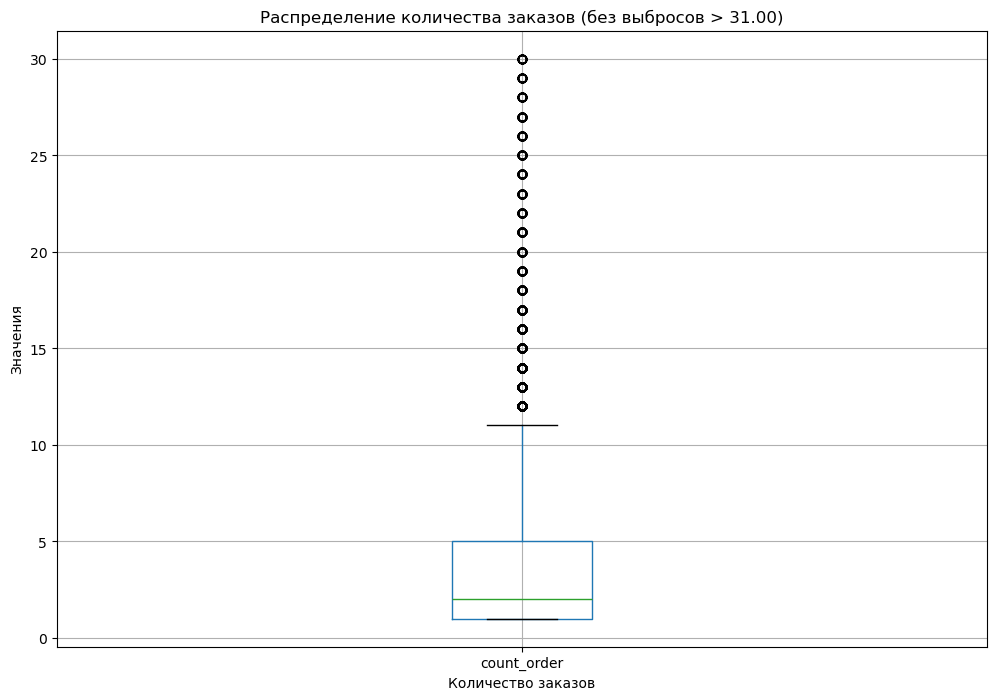

Среднее значение по количеству заказов: 3.99
Медиана по количеству заказов: 2.0
Было строк: 21705
Стало строк: 20594
Удалено выбросов: 1111
Процент удаленых выбросов: 5.12%
Выбросами считались значения свыше: 31.00


In [37]:
# Вычисляем 99-й перцентиль
threshold_profiles = df_profile['count_order'].quantile(0.95)

# Фильтруем строки, где выручка МЕНЬШЕ порога (оставляем 99% данных)
df_profile_filtred = df_profile[df_profile['count_order'] < threshold_profiles]

# Строим boxplot
plt.figure(figsize=(12, 8))
df_profile_filtred.boxplot(column='count_order')
plt.title(f'Распределение количества заказов (без выбросов > {threshold_profiles:.2f})')
plt.xlabel('Количество заказов')
plt.ylabel('Значения')
plt.show()

# Проверяем, сколько строк удалили
print(f"Среднее значение по количеству заказов: {round(df_profile_filtred['count_order'].mean(),2)}")
print(f"Медиана по количеству заказов: {df_profile_filtred['count_order'].median()}")
print(f"Было строк: {len(df_profile)}")
print(f"Стало строк: {len(df_profile_filtred)}")
print(f"Удалено выбросов: {len(df_profile) - len(df_profile_filtred)}")
print(f"Процент удаленых выбросов: {round((100*(len(df_profile) - len(df_profile_filtred))/len(df_profile)),2)}%")
print(f"Выбросами считались значения свыше: {threshold_profiles:.2f}")

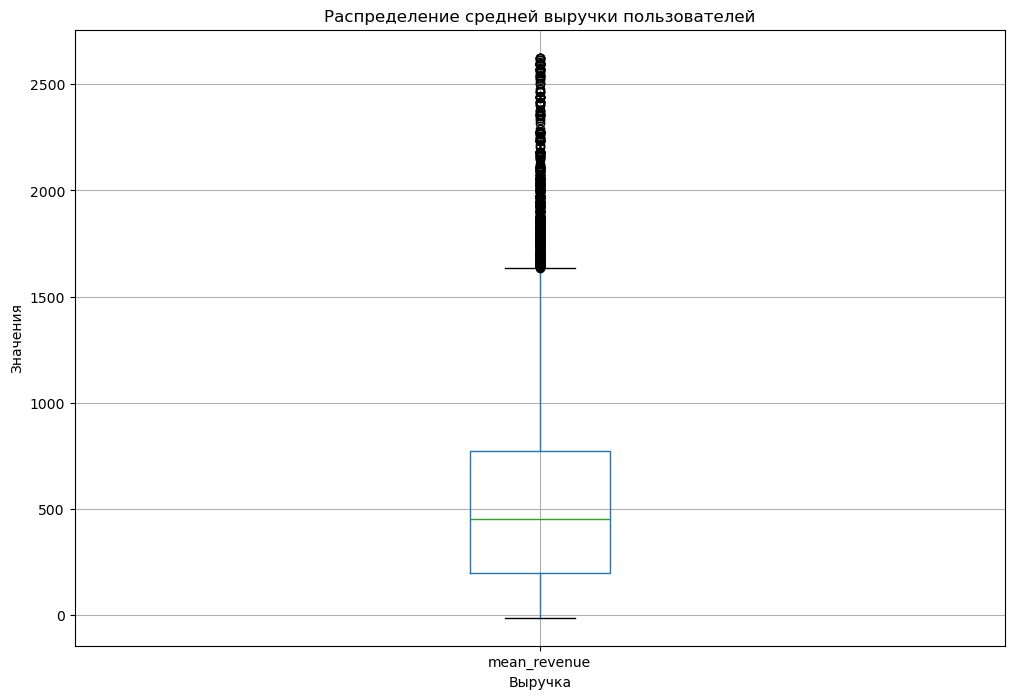

Среднее значение по средней выручке: 541
Медиана по средней выручке: 454


In [38]:
# Строим boxplot
plt.figure(figsize=(12, 8))
df_profile_filtred.boxplot(column='mean_revenue')
plt.title('Распределение средней выручки пользователей')
plt.xlabel('Выручка')
plt.ylabel('Значения')
plt.show()

print(f"Среднее значение по средней выручке: {round(df_profile_filtred['mean_revenue'].mean())}")
print(f"Медиана по средней выручке: {round(df_profile_filtred['mean_revenue'].median())}")

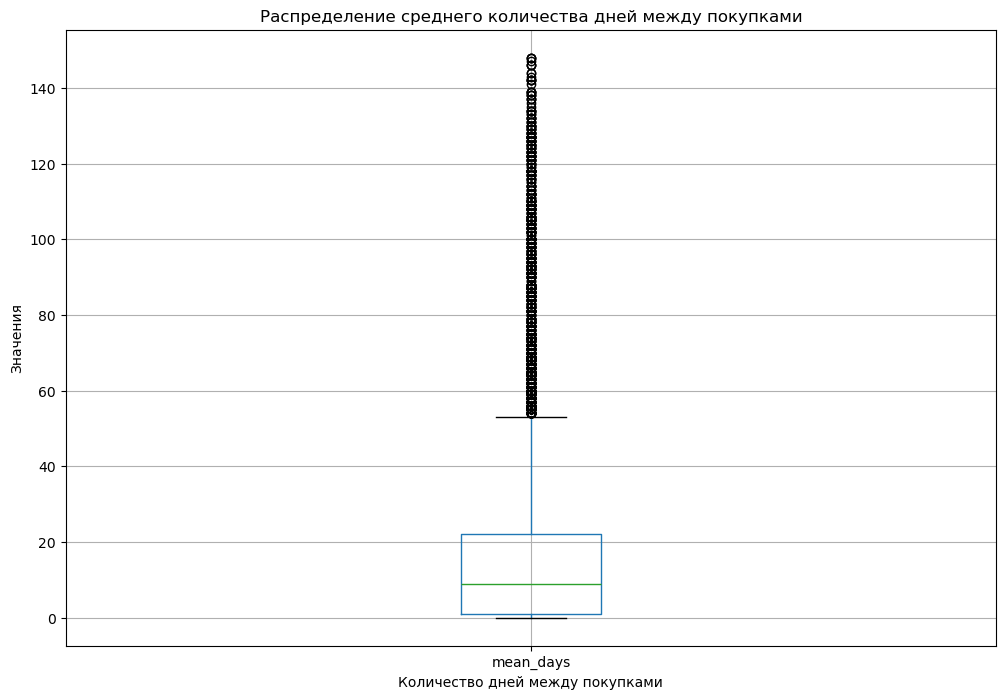

Среднее значение среднего количества дней между покупками: 17
Медиана среднего количества дней между покупками: 9


In [39]:
# Строим boxplot
plt.figure(figsize=(12, 8))
df_profile_filtred.boxplot(column='mean_days')
plt.title('Распределение среднего количества дней между покупками')
plt.xlabel('Количество дней между покупками')
plt.ylabel('Значения')
plt.show()

print(f"Среднее значение среднего количества дней между покупками: {round(df_profile_filtred['mean_days'].mean())}")
print(f"Медиана среднего количества дней между покупками: {round(df_profile_filtred['mean_days'].median())}")

In [40]:
# Считаем пользователей в выборке
count_users_filtred = df_profile_filtred['user_id'].count()
print(f'Общее число пользователей в выборке: {count_users_filtred}.')

# Считаем среднюю выручку
mean_revenue_filtred = round((df_profile_filtred['mean_revenue'].sum()/ count_users_filtred),2)
print(f'Средняя выручка с одного заказа: {mean_revenue_filtred}.')

# Считаем доли пользователей совершивших 2 и более, а также 5 и более покупок
share_two_filtred = round((df_profile_filtred['is_two'].sum()/ count_users_filtred),2)
share_five_filtred = round((df_profile_filtred['is_five'].sum()/ count_users_filtred),2)
print(f'Доля пользователей, совершивших 2 и более заказа: {share_two_filtred}.')
print(f'Доля пользователей, совершивших 5 и более заказа: {share_five_filtred}.')

# Выводим информацию по удаленным выбросам
print(f"Удалено выбросов: {len(df_profile) - len(df_profile_filtred)}")
print(f"Процент удаленых выбросов: {round((100*(len(df_profile) - len(df_profile_filtred))/len(df_profile)),2)}%")

Общее число пользователей в выборке: 20594.
Средняя выручка с одного заказа: 541.33.
Доля пользователей, совершивших 2 и более заказа: 0.6.
Доля пользователей, совершивших 5 и более заказа: 0.25.
Удалено выбросов: 1111
Процент удаленых выбросов: 5.12%


In [41]:
df_profile_filtred.describe()

,first_order_dt,last_order_dt,count_order,mean_revenue,mean_tickets,mean_days,is_two,is_five
count,20594,20594,20594.000000,20594.000000,20594.000000,12336.000000,20594.000000,20594.000000
mean,2024-08-13 07:04:09.276488448,2024-09-16 04:04:27.106924288,3.993785,541.327960,2.692872,17.025211,0.595513,0.250947
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,-11.000000,1.000000,0.000000,0.000000,0.000000
25%,2024-07-01 00:00:00,2024-08-22 00:00:00,1.000000,201.000000,2.000000,1.000000,0.000000,0.000000
50%,2024-08-14 00:00:00,2024-09-30 00:00:00,2.000000,454.000000,3.000000,9.000000,1.000000,0.000000
75%,2024-09-25 00:00:00,2024-10-20 00:00:00,5.000000,775.000000,3.000000,22.000000,1.000000,1.000000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,30.000000,2625.000000,5.000000,148.000000,1.000000,1.000000
std,NaN,NaN,4.989715,435.614407,0.907773,22.858101,0.490804,0.433569


### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
- При проверке датасета были выявлены выбросы в стобцах `count_order`, `mean_revenue`, `mean_days`.
- Для столбца `count_order` было принято решение удалить выбросы ориентируясь на 95 перцентиль (при этом выбросами считались значения превышающие 31), до удаления максимальное значение для этого столбца было 9972, при том что 75 перцентилем является значение 5. В связи с тем что максимальное значение отличается почти в 2000 раз его было решено удалить.
- Значения для столбцов `mean_revenue`, `mean_days` было решено оставить в выборке тк максимальные значения отличаются не так критично и вполне могут считаться нормальными (средняя выручка в 2625 не кажется неестественной, как и разница в днях между покупками в 148 дней, в отличии от 9972 заказов на одного пользователя).

- В результате удаления выбросов количество строк было сокращено на 1111, что соответствует 5.12% от первоначальной выборки.
- Из полученных данных можно сделать вывод что большинство пользователей - 60% совершают как минимум 2 покупки, а так же что 25% совершают не менее 5 покупок. При этом средняя выручка с одного заказа составляет ~541 руб.. Общее количество пользователей из которых считалась статистика составляет 20594.

## Исследовательский анализ данных
Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.

### Задача 4.1. 
Исследование признаков первого заказа и их связи с возвращением на платформу
- Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

#### Задача 4.1.1. 
Изучите распределение пользователей по признакам.
Сгруппируйте пользователей:
- по типу их первого мероприятия;
- по типу устройства, с которого совершена первая покупка;
- по региону проведения мероприятия из первого заказа;
- по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

In [42]:
df_profile_filtred.columns

Index(['user_id', 'first_order_dt', 'last_order_dt', 'first_device',
       'first_region', 'first_service', 'first_event_type', 'count_order',
       'mean_revenue', 'mean_tickets', 'mean_days', 'is_two', 'is_five'],
      dtype='object')

In [43]:
def show_users_stats(tmp0, column1, column2):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    users_stats = pd.DataFrame({
        'Кол-во пользователей': tmp0.groupby(column1)[column2].count(),
        'Доля пользователей': tmp0.groupby(column1)[column2].count() / tmp0[column1].count()
    })
   
    
    #Сортировка по количеству пользователей
    users_stats = users_stats.sort_values('Кол-во пользователей', ascending=False)
    
    # Форматируем при выводе через Styler
    return (users_stats.style.format({'Доля пользователей': '{:.3f}'}).background_gradient(cmap='coolwarm'))

In [44]:
# Выводим статистику по типу первого мероприятия
show_users_stats(df_profile_filtred, 'first_event_type', 'user_id')

,Кол-во пользователей,Доля пользователей
first_event_type,,
концерты,9149,0.444
другое,5093,0.247
театр,4045,0.196
стендап,1053,0.051
спорт,757,0.037
выставки,404,0.020
ёлки,93,0.005


In [45]:
# Выводим статистику по типу устройства с которого был совершен первый заказ
show_users_stats(df_profile_filtred, 'first_device', 'user_id')

,Кол-во пользователей,Доля пользователей
first_device,,
mobile,17096,0.830
desktop,3498,0.170


In [46]:
# Выводим статистику по месту проведения первого мероприятия
show_users_stats(df_profile_filtred, 'first_region', 'user_id')

,Кол-во пользователей,Доля пользователей
first_region,,
Каменевский регион,6748,0.328
Североярская область,3545,0.172
Широковская область,1175,0.057
Озернинский край,654,0.032
Малиновоярский округ,512,0.025
Травяная область,465,0.023
Шанырский регион,462,0.022
Светополянский округ,437,0.021
Речиновская область,420,0.020


In [47]:
# Выводим статистику по оператору продавшему первый заказ
show_users_stats(df_profile_filtred, 'first_service', 'user_id')

,Кол-во пользователей,Доля пользователей
first_service,,
Билеты без проблем,4905,0.238
Мой билет,2833,0.138
Лови билет!,2690,0.131
Билеты в руки,2410,0.117
Облачко,2107,0.102
Весь в билетах,1220,0.059
Лучшие билеты,1123,0.055
Прачечная,550,0.027
Край билетов,438,0.021


#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
- На тепловых картах можно заметить ярко выраженный сегмент "концерты" (9149 пользоватлей) при рассмотрении пользователей по признаку первого посещенного события, в сравнении с сегментами "другое" (5093 пользователей) и "театр" (4045 пользователей) отличие почти в два раза. Доля пользователей при первом заказе выбравших данный тип мероприятий 0,444, что близко к половине от общего количества пользователей.

- При рассмотрении предпочтений пользователей в выборе между типами устройств при оформлении первого заказа очевидной точкой входа является мобильный сегмент (17096 пользователей) с долей 0.83.

- При рассмотрени данных в разрезе региона в котором проходило первое мероприятие, можно заметить, что наибольшей популярностью пользуется "Каменевский регион" (6748 пользователей) при доле 0.328 среди всех пользователей.

- Наиболее популярным оператором при первой покупке билетов стал "Билеты без проблем" на их счету 4905 пользователей составляющих 0.238 от всех пользователей, отличие от второго по популярности оператора "Мой билет" весьма значительное - 2833 пользователей и их доля составляет 0.138 от общего числа.

В каждом из признаков можно заметить "точки входа", в некоторых случаях особенно выраженные, за исключение таких сегментов пользователи распределены равномерно, по оставшимся сегментам.

#### Задача 4.1.2. 
Проанализируйте возвраты пользователей:
- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.

Ответьте на вопросы:
- Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
- Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

In [48]:
def show_users_stats_bin(tmp0, column1, column2):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    users_stats = pd.DataFrame({
        'Доля пользователей': tmp0.groupby(column1)[column2].sum() / tmp0[column1].count()
    })
   
    
    #Сортировка по количеству пользователей
    users_stats = users_stats.sort_values('Доля пользователей', ascending=False).head(10)
    
    # Форматируем при выводе через Styler
    return (users_stats.style.format({'Доля пользователей': '{:.3f}'}).background_gradient(cmap='coolwarm'))

In [49]:
# Выводим статистику по типу первого мероприятия
show_users_stats_bin(df_profile_filtred, 'first_event_type', 'is_two')

,Доля пользователей
first_event_type,
концерты,0.267
другое,0.143
театр,0.121
стендап,0.030
спорт,0.020
выставки,0.012
ёлки,0.002


In [50]:
# Выводим статистику по типу устройства с которого был совершен первый заказ
show_users_stats_bin(df_profile_filtred, 'first_device', 'is_two')

,Доля пользователей
first_device,
mobile,0.490
desktop,0.105


In [51]:
# Выводим статистику по месту проведения первого мероприятия
show_users_stats_bin(df_profile_filtred, 'first_region', 'is_two')

,Доля пользователей
first_region,
Каменевский регион,0.198
Североярская область,0.106
Широковская область,0.036
Озернинский край,0.017
Шанырский регион,0.014
Светополянский округ,0.014
Малиновоярский округ,0.014
Травяная область,0.013
Речиновская область,0.013


In [52]:
# Выводим статистику по оператору продавшему первый заказ
show_users_stats_bin(df_profile_filtred, 'first_service', 'is_two')

,Доля пользователей
first_service,
Билеты без проблем,0.140
Мой билет,0.081
Лови билет!,0.077
Билеты в руки,0.071
Облачко,0.061
Весь в билетах,0.036
Лучшие билеты,0.033
Прачечная,0.016
Край билетов,0.013


#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Чаще всего на Яндекс Афишу возвращаются следущие сегменты пользователей:

- По оператору: пользователи, совершившие первый заказ через оператора «Билеты без проблем».

- По устройству: пользователи мобильных устройств.

- По типу мероприятия: пользователи, первым заказом которых были концерты.

- По региону: пользователи из Каменевского региона.


Сегменты, где пользователи чаще совершают повторный заказ, чем в среднем по выборке «точки входа»:

- «Билеты без проблемы» среди операторов.

- Мобильные устройства среди типов устройств.

- Концерты, «другое», театр среди типов мероприятий.

- Каменевский регион и Северовская область среди регионов.

#### ✅ Задача 4.1.3. 
Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:
- Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

</font><font color='Blue'><b>Комментарий V1</b></font><br>
- Гипотеза 1

По результатам анализа можно сказать что теория подтвердилась частично, тип меорприятий действительно влияет на вероятность возврата пользователя, однако это справделиво для пользователей совершивших свой первый заказ на "концерт" (вернулись 26,7%), а вот тех кто в первую очеред заказал "спорт" возвращают в разы реже (вернулись 2%).

- Гипотеза 2

Для ответа на гипотезу с такой формулировкой недостаточно данных, тк в предложенных данных отсутствует информация о том на сколько активно пользователи посещают мероприятия.

Однако, если исходить из имеющейся информации можно сказать, что в регионах где больше пользователей совершили хотя бы один заказ действительно больше вероятность возврата. Например в "Каменевский регион" свой первый заказ совершили 6748 пользователей из них совершили второй и более заказ 19,8%, в то время как в "Североярская область" первый заказ совершили 3545 пользователей, а второй и более заказ из них совершили 10,6%. Таким образом теория подтверждена.

### Задача 4.2. 
Исследование поведения пользователей через показатели выручки и состава заказа
- Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.
- Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

####  Задача 4.2.1. 
Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

Постройте сравнительные гистограммы распределения средней выручки с билета ( avg_revenue_rub ):
- для пользователей, совершивших один заказ;
- для вернувшихся пользователей, совершивших 2 и более заказа.

Ответьте на вопросы: 
- В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
- Есть ли различия между группами?

`Рекомендации:`
- Используйте одинаковые интервалы ( bins ) и прозрачность ( alpha ), чтобы визуально сопоставить распределения.
- Задайте параметру density значение True, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

In [53]:
df_profile_filtred.columns

Index(['user_id', 'first_order_dt', 'last_order_dt', 'first_device',
       'first_region', 'first_service', 'first_event_type', 'count_order',
       'mean_revenue', 'mean_tickets', 'mean_days', 'is_two', 'is_five'],
      dtype='object')

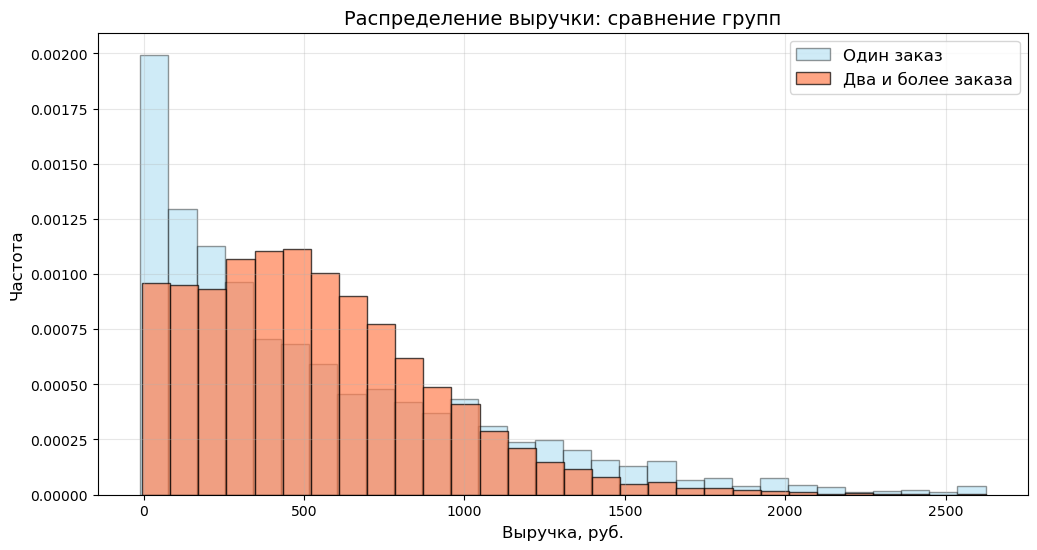

In [54]:
# Фильтрация данных
data_filtered_two_true = df_profile_filtred[df_profile_filtred['is_two'] == 1] 
data_filtered_two_false = df_profile_filtred[df_profile_filtred['is_two'] == 0]

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Гистограмма 1: Только is_two == 0
plt.hist(
    data_filtered_two_false['mean_revenue'], 
    bins=30, 
    edgecolor='black', 
    alpha=0.4,  # Прозрачность для наложения
    color='skyblue',
    label='Один заказ',
    density=True
)

# Гистограмма 2: Только is_two == 1
plt.hist(
    data_filtered_two_true['mean_revenue'], 
    bins=30,  # Лучше использовать те же bins для сравнения
    edgecolor='black', 
    alpha=0.7,  # Меньше прозрачности, чтобы была видима
    color='coral',
    label='Два и более заказа',
    density=True
)

# Настройка графика
plt.title('Распределение выручки: сравнение групп', fontsize=14)
plt.xlabel('Выручка, руб.', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Диапазоны концентрации пользователей:

Один заказ: Пользователи сконцентрированы в основном в диапазоне 0–500 рублей, с пиком вероятности около 0.00175 в районе 150–250 рублей.

Два и более заказа: Пользователи также сконцентрированы в диапазоне 0–500 рублей, но с более выраженным пиком около 100–200 рублей (вероятность около 0.002).

Различия между группами:

Высота пиков: У пользователей с двумя и более заказами пик распределения выше, что говорит о большей концентрации в низком диапазоне выручки.

Хвост распределения: У группы с одним заказом наблюдается более длинный хвост в сторону высокой выручки (до ~2500 рублей), что указывает на наличие единичных крупных заказов.

Общая форма: Обе группы имеют правостороннее распределение с основным скоплением в начале шкалы, но группа с повторными заказами выглядит более сконцентрированной.

Можно сделать вывод, что повторные покупатели склонны совершать заказы с меньшей средней выручкой, но делают это чаще. Однократные покупатели демонстрируют более широкий разброс по сумме заказа, включая некоторые крупные покупки. Это может указывать на то, что сервис чаще возвращают пользователи, совершающие небольшие, но частые заказы.

####  Задача 4.2.2. 
Сравните распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

- Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

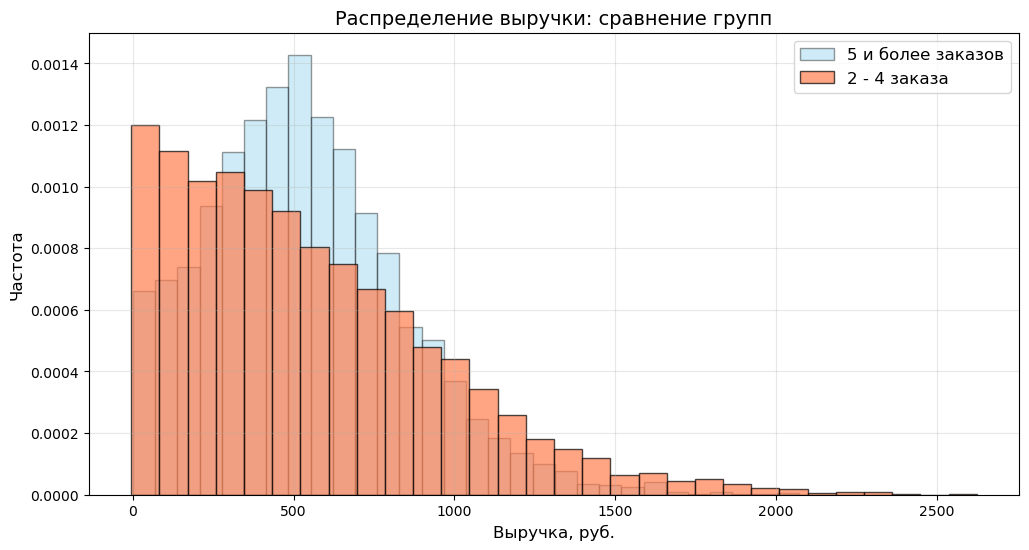

In [55]:
# Фильтрация данных
data_filtered_two_true = df_profile_filtred[df_profile_filtred['is_two'] == 1] 
data_filtered_five_true = df_profile_filtred[df_profile_filtred['is_five'] == 1]

# Объединяем датафреймы и оставляем только уникальные строки из data_filtered_two_true (оставляем только пользователей с заказами 2-4)
result = data_filtered_two_true.merge(data_filtered_five_true, how='left', indicator=True)
result = result[result['_merge'] == 'left_only'].drop('_merge', axis=1)

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Гистограмма 1: Только is_five == 1
plt.hist(
    data_filtered_five_true['mean_revenue'], 
    bins=30, 
    edgecolor='black', 
    alpha=0.4,  # Прозрачность для наложения
    color='skyblue',
    label='5 и более заказов',
    density=True
)

# Гистограмма 2: Только is_two == 1, без is_five == 1
plt.hist(
    result['mean_revenue'], 
    bins=30,  # Лучше использовать те же bins для сравнения
    edgecolor='black', 
    alpha=0.7,  # Меньше прозрачности, чтобы была видима
    color='coral',
    label='2 - 4 заказа',
    density=True
)

# Настройка графика
plt.title('Распределение выручки: сравнение групп', fontsize=14)
plt.xlabel('Выручка, руб.', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Из графика можно заметить различия между группами:

Пользователи, совершившие 5 и более заказов, имеют более низкую среднюю выручку с заказа, но более высокую концентрацию в низком ценовом диапазоне.

Пользователи с 2–4 заказами показывают большую вариативность и более высокие возможные суммы заказа.

#### Задача 4.2.3. 
Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

Изучите распределение пользователей по среднему количеству билетов в заказе ( avg_tickets_count ) и опишите основные 
наблюдения.

Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
- от 1 до 2 билетов;
- от 2 до 3 билетов;
- от 3 до 5 билетов;
- от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.

Ответьте на вопросы:
- Как распределены пользователи по сегментам — равномерно или сконцентрировано?
- Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

In [56]:
df_segments = df_profile_filtred.copy()

In [57]:
# Добавляем сегментацию по количеству билетов
def assign_segment(count):
    if count < 2:
        return 'от 1 до 2 билетов'
    elif count < 3:
        return 'от 2 до 3 билетов'
    elif count < 5:
        return 'от 3 до 5 билетов'
    elif count >= 5:
        return 'от 5 и более билетов'
    else:
        return 'Ошибка'

df_segments['segments'] = df_segments['mean_tickets'].apply(assign_segment)

In [58]:
df_segments

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,count_order,mean_revenue,mean_tickets,mean_days,is_two,is_five,segments
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1522.0,4.0,NaN,0,0,от 3 до 5 билетов
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.0,3.0,75.0,1,0,от 3 до 5 билетов
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.0,3.0,51.0,1,0,от 3 до 5 билетов
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,918.0,4.0,NaN,0,0,от 3 до 5 билетов
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.0,2.0,16.0,1,0,от 2 до 3 билетов
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21699,ffed3ff067d4f12,2024-07-31,2024-10-17,mobile,Малиновая область,Лучшие билеты,другое,4,51.0,2.0,26.0,1,0,от 2 до 3 билетов
21700,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.0,3.0,13.0,1,1,от 3 до 5 билетов
21701,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,851.0,2.0,74.0,1,0,от 2 до 3 билетов
21703,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,662.0,2.0,NaN,0,0,от 2 до 3 билетов


In [59]:
def show_users_stats_bin(tmp0, column1, column2):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    users_stats_bin = pd.DataFrame({
        'Кол-во пользователей': tmp0.groupby(column1)[column2].count(),
        'Доля пользователей совершивших повторные заказы': tmp0.groupby(column1)[column2].sum().astype('float') / tmp0[column1].count()
    })
   
    
    #Сортировка по количеству пользователей
    users_stats_bin = users_stats_bin.sort_values('Кол-во пользователей', ascending=False)
    
    # Форматируем при выводе через Styler
    return (users_stats_bin.style.format({'Доля пользователей совершивших повторные заказы': '{:.3f}'}).background_gradient(cmap='coolwarm'))

In [60]:
show_users_stats_bin(df_segments, 'segments', 'is_two')

,Кол-во пользователей,Доля пользователей совершивших повторные заказы
segments,,
от 3 до 5 билетов,10925,0.327
от 2 до 3 билетов,7695,0.251
от 1 до 2 билетов,1474,0.014
от 5 и более билетов,500,0.003


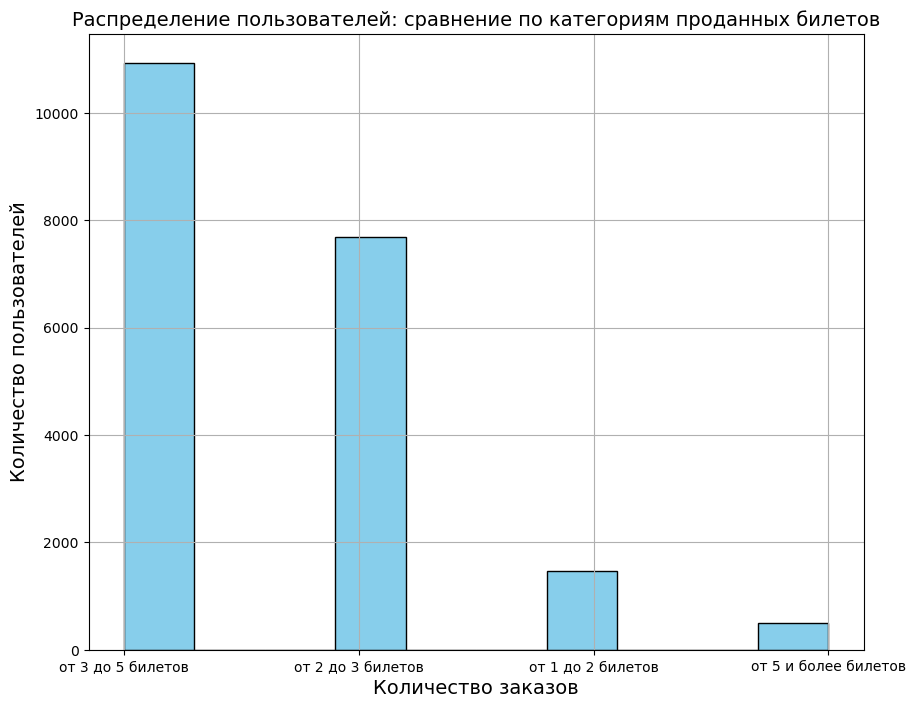

In [61]:
# Для наглядности добавляем гистаграмму
# Создаем фигуру
plt.figure(figsize=(10, 8))

# Гистограмма
plt.hist(
    df_segments['segments'], 
    bins=10,
    edgecolor='black', 
    color='skyblue'
)

# Настройка графика
plt.title('Распределение пользователей: сравнение по категориям проданных билетов', fontsize=14)
plt.xlabel('Количество заказов', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.grid()
plt.show()

#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
- Пользователи сконцентрированы в сегментах от 2 до 3 билетов и от 3 до 5 билетов (вместе ~18 620 пользователей, подавляющее большинство).

Сегменты 1–2 билета и 5+ билетов значительно меньше.

- Из тепловой карты можно заметить аномальные доли:

От 1 до 2 билетов: 1.4% — очень низкий показатель возврата.

От 5 и более билетов: 0.3% — почти нулевой показатель.

От 3 до 5 билетов: 32.7% — самый высокий показатель лояльности.

От 2 до 3 билетов: 25.1% — также высокий показатель.

- Наиболее лояльные пользователи — те, кто в среднем заказывает от 2 до 5 билетов за раз (повторяют покупку в 25–33% случаев).

- Пользователи с очень малым (1–2) или очень большим (5+) средним количеством билетов в заказе почти не возвращаются.

- Пик лояльности наблюдается в сегменте 3–5 билетов.

### Задача 4.3. 
Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:
- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

#### Задача 4.3.1. 
Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.
- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.

- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

In [62]:
df_segments_week = df_profile_filtred.copy()

In [63]:
df_segments_week['weekday'] = df_segments_week['first_order_dt'].dt.weekday

In [64]:
show_users_stats_bin(df_segments_week, 'weekday', 'is_two')

,Кол-во пользователей,Доля пользователей совершивших повторные заказы
weekday,,
4,3142,0.089
5,3103,0.091
3,3011,0.085
1,2991,0.087
2,2946,0.087
0,2792,0.083
6,2609,0.073


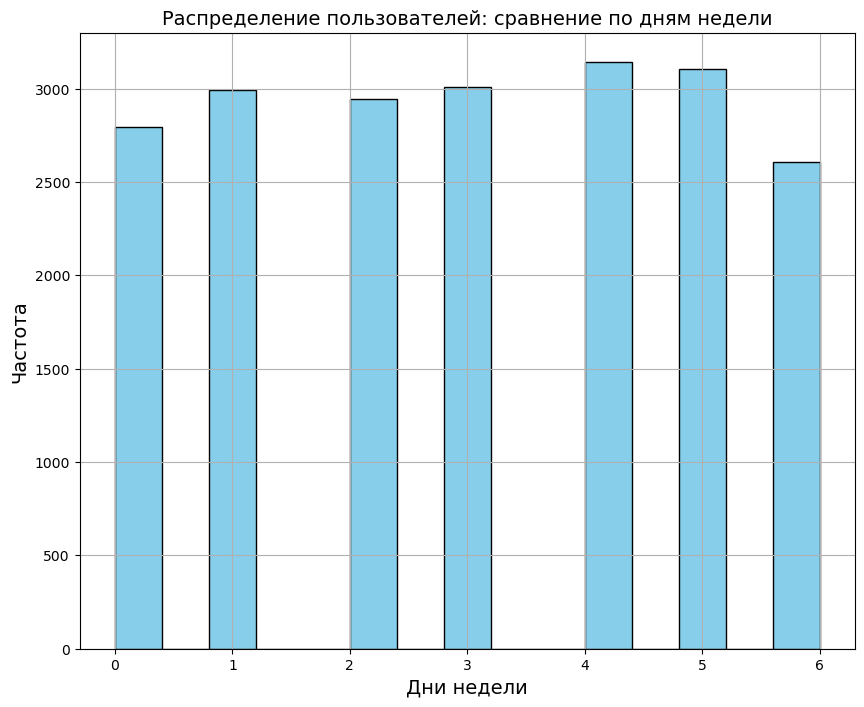

In [65]:
# Для наглядности добавляем гистаграмму
# Создаем фигуру
plt.figure(figsize=(10, 8))

# Гистограмма 
plt.hist(
    df_segments_week['weekday'], 
    bins=15,
    edgecolor='black', 
    color='skyblue'
)

# Настройка графика
plt.title('Распределение пользователей: сравнение по дням недели', fontsize=14)
plt.xlabel('Дни недели', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid()
plt.show()

#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
- Распределение количества пользователей по дням недели относительно равномерное, с небольшим пиком в пятницу (4) и спадом в воскресенье (6).

- Доля повторных покупок колеблется в узком диапазоне 7.3% – 9.1%.

- Можно сказать что день недели влияет, но в незначительной мере:

Наиболее вероятно возвращаются те, кто совершил первую покупку в пятницу или субботу.

Наименее вероятно возвращаются те, кто совершил первую покупку в воскресенье.

Однако разница между днями не превышает 2%.

#### Задача 4.3.2. 
Изучите, как средний интервал между заказами влияет на удержание клиентов.

Рассчитайте среднее время между заказами для двух групп пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

In [66]:
mean_for_two = round(df_profile_filtred.groupby('is_two')['mean_days'].mean())
mean_for_five = round(df_profile_filtred.groupby('is_five')['mean_days'].mean())

print(f'В группе совершивших 2-4 заказа средний интервал между заказами: {mean_for_two[1]}')
print(f'В группе совершивших 5 и более заказов средний интервал между заказами: {mean_for_five[1]}')

В группе совершивших 2-4 заказа средний интервал между заказами: 17.0
В группе совершивших 5 и более заказов средний интервал между заказами: 11.0


#### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Из полученных значений можно сделать следующий вывод:
- Чем короче средний интервал между заказами, тем выше вероятность, что пользователь станет постоянным клиентом и совершит больше покупок.

- Пользователи с интервалом ~11 дней демонстрируют более стабильное и частое повторное взаимодействие с сервисом.

- Пользователи с интервалом ~17 дней хотя и возвращаются, но делают это реже, что может указывать на более низкий уровень вовлечённости.

## Корреляционный анализ количества покупок и признаков пользователя
Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

#### Задача 4.4.1 
Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов ( total_orders ). При необходимости используйте параметр interval_cols для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в total_orders. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю total_orders, а затем повторите корреляционный анализ. 

Выделите такие сегменты:
- 1 заказ;
- от 2 до 4 заказов;
- от 5 и выше.

Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

In [67]:
df_profile_filtred.columns

Index(['user_id', 'first_order_dt', 'last_order_dt', 'first_device',
       'first_region', 'first_service', 'first_event_type', 'count_order',
       'mean_revenue', 'mean_tickets', 'mean_days', 'is_two', 'is_five'],
      dtype='object')

interval columns not set, guessing: ['count_order', 'mean_revenue', 'mean_tickets', 'mean_days']
Корреляция количества заказов со всеми остальными параметрами (без самого количества заказов):
mean_days           0.487031
last_order_dt       0.398315
first_order_dt      0.396456
mean_tickets        0.339548
mean_revenue        0.264168
first_device        0.046830
first_service       0.041190
first_event_type    0.034911
first_region        0.000000
Name: count_order, dtype: float64


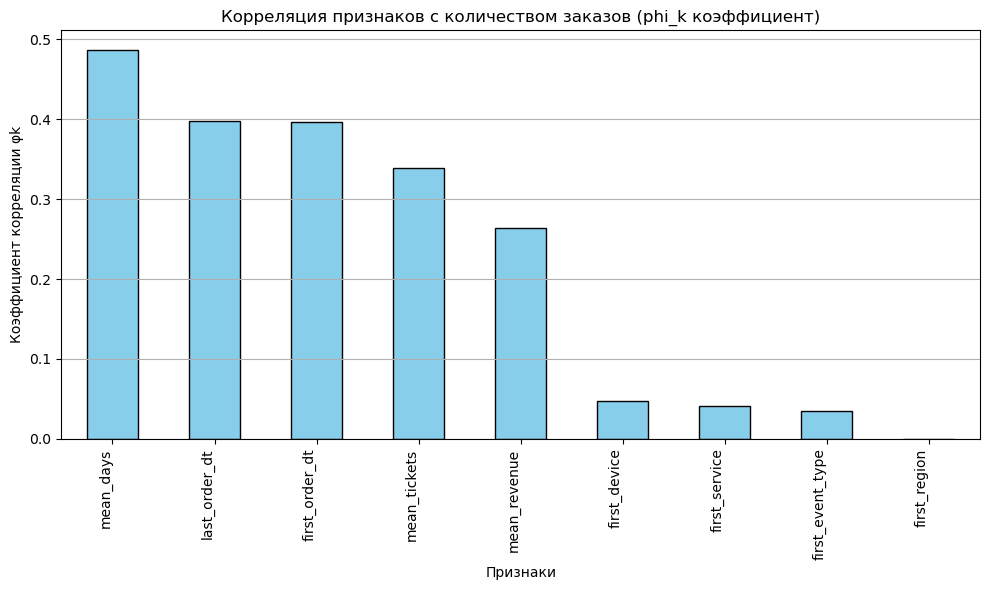

In [68]:
# В список столбцов не включаем столбцы is_two, is_five которые формировались из столбца count_order
correlation_matrix = df_profile_filtred[['first_order_dt', 'last_order_dt', 'first_device',
                                       'first_region', 'first_service', 'first_event_type',
                                       'count_order', 'mean_revenue', 'mean_tickets',
                                       'mean_days']].phik_matrix(interval_cols=None)

# Корреляции с count_order, исключая сам count_order
mean_days_correlations = correlation_matrix['count_order'].drop('count_order').sort_values(ascending=False)

print('Корреляция количества заказов со всеми остальными параметрами (без самого количества заказов):')
print(mean_days_correlations)

# Строим барплот
plt.figure(figsize=(10, 6))
mean_days_correlations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Корреляция признаков с количеством заказов (phi_k коэффициент)')
plt.ylabel('Коэффициент корреляции φk')
plt.xlabel('Признаки')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

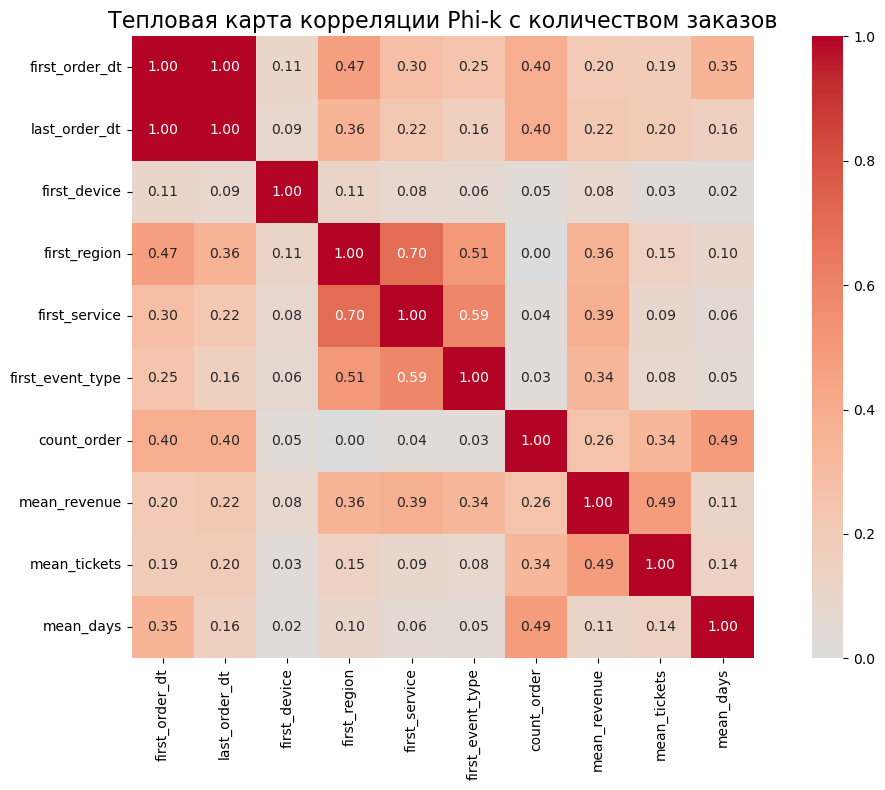

In [69]:
# Создаем тепловую карту с count_order
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True,     # Показать числа в ячейках
            fmt='.2f',      # Формат чисел: 2 знака после запятой
            cmap='coolwarm', # Цветовая схема
            center=0,       # Центр цветовой шкалы на 0
            square=True)    # Квадратные ячейки

plt.title('Тепловая карта корреляции Phi-k с количеством заказов', fontsize=16)
plt.tight_layout()
plt.show()

In [70]:
df_tree_segments = df_profile_filtred.copy()

In [71]:
# Добавляем сегментацию по количеству билетов
def assign_tree_segment(count):
    if count < 2:
        return '1 заказ'
    elif count <= 4:
        return 'от 2 до 4 билетов'
    elif count >= 5:
        return 'от 5 и более билетов'
    else:
        return 'Ошибка'

df_tree_segments['segments'] = df_tree_segments['count_order'].apply(assign_tree_segment)

In [72]:
df_tree_segments.columns

Index(['user_id', 'first_order_dt', 'last_order_dt', 'first_device',
       'first_region', 'first_service', 'first_event_type', 'count_order',
       'mean_revenue', 'mean_tickets', 'mean_days', 'is_two', 'is_five',
       'segments'],
      dtype='object')

interval columns not set, guessing: ['mean_revenue', 'mean_tickets', 'mean_days']
Корреляция количества заказов со всеми остальными параметрами (без самого количества заказов):
mean_days           0.487031
last_order_dt       0.398315
first_order_dt      0.396456
mean_tickets        0.339548
mean_revenue        0.264168
first_device        0.046830
first_service       0.041190
first_event_type    0.034911
first_region        0.000000
Name: count_order, dtype: float64


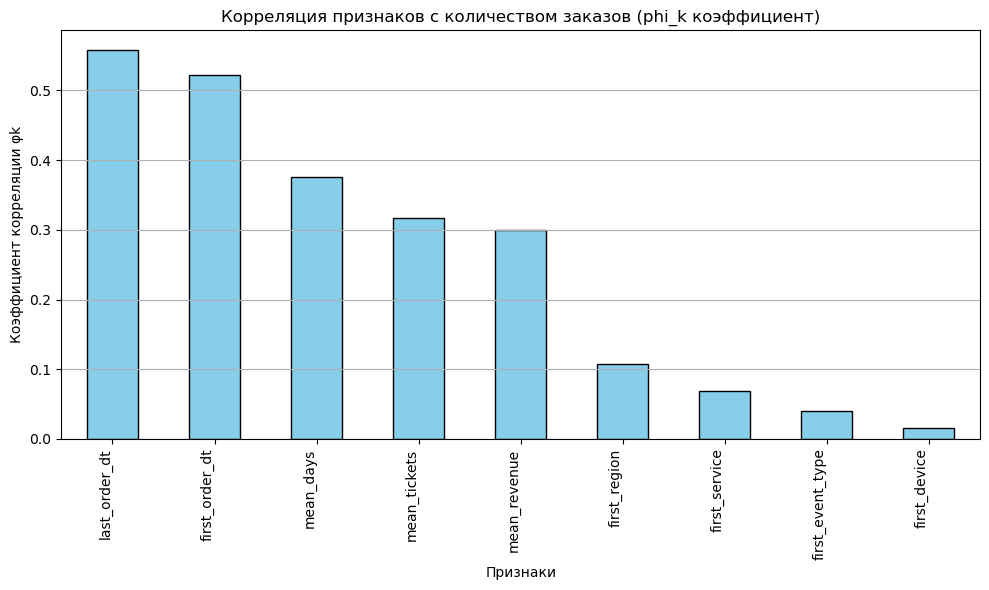

In [73]:
# В список столбцов не включаем столбцы на которых формировался столбец segments и ему подобные count_order, is_two, is_five
correlation_matrix_segments = df_tree_segments[['first_order_dt', 'last_order_dt', 'first_device',
                                       'first_region', 'first_service', 'first_event_type',
                                       'mean_revenue', 'mean_tickets', 'mean_days', 'segments']].phik_matrix(interval_cols=None)

# Корреляции с segments, исключая сам segments
mean_days_correlations_segments = correlation_matrix_segments['segments'].drop('segments').sort_values(ascending=False)

print('Корреляция количества заказов со всеми остальными параметрами (без самого количества заказов):')
print(mean_days_correlations)

# Строим барплот
plt.figure(figsize=(10, 6))
mean_days_correlations_segments.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Корреляция признаков с количеством заказов (phi_k коэффициент)')
plt.ylabel('Коэффициент корреляции φk')
plt.xlabel('Признаки')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

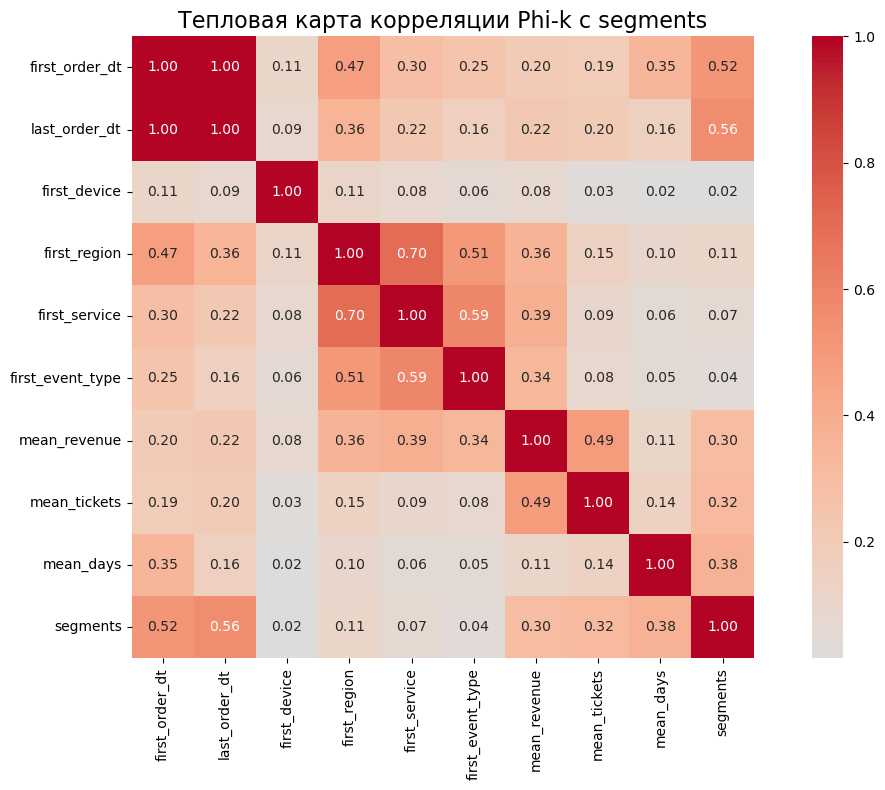

In [74]:
# Создаем тепловую карту с segments
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_segments, 
            annot=True,     # Показать числа в ячейках
            fmt='.2f',      # Формат чисел: 2 знака после запятой
            cmap='coolwarm', # Цветовая схема
            center=0,       # Центр цветовой шкалы на 0
            square=True)    # Квадратные ячейки

plt.title('Тепловая карта корреляции Phi-k с segments', fontsize=16)
plt.tight_layout()
plt.show()

### Промежуточный вывод

</font><font color='Blue'><b>Комментарий V1</b></font><br>
Наиболее яркая корреляция с количеством заказов выявлена для:

`last_order_dt` — дата последнего заказа (корреляция 0.56 с сегментами)

`first_order_dt` — дата первого заказа (0.52)

`mean_days` — средний интервал между заказами (0.38)

`mean_tickets` — среднее количество билетов (0.32)

`mean_revenue` — средняя выручка (0.30)

В целом можно сделать вывод:
- Самые информативные признаки — временные (`last_order_dt`, `first_order_dt`, `mean_days`).
- Географические/технические признаки (`first_device`, `first_region`, `first_service`) почти не влияют на количество заказов.
- Сегментация по количеству заказов позволила выявить скрытые закономерности, которые были не видны при анализе исходной переменной `count_order`.

## Общие выводы и рекомендации
В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:
- Информацию о данных, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- Основные результаты анализа. Например, укажите:
- Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
- Какие признаки первого заказа связаны с возвратом пользователей?
- Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
- Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
- Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.
- В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

- 1 Загрузка данных и знакомство с ними

Выгруженный из СУБД датасет содержит 290611 строк и 15 колонок, занимает 33.3+ MB. Пропуски обнаружены только в колонке `days_since_prev` (21933 шт.) как и предполагалось на этапе подготовки SQL запроса. Названия колонок уже приведено к `snake_case`.

Типы данных распознаны корректно: `datetime64[ns]`(2 колонки), `float64`(2 колонки), `int64`(3 колонки), `object`(8 колонок).

Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

- 2 Предобработка данных

Пропуски в данных присутствуют только в столбце `days_since_prev` (21933 пропусков) как и предполагалось при выгрузке данных.

В процессе предобратки были сокращены размерности для трех столбцов - `revenue`, `tickets_count`, `days_since_prev`. Для остальных столбцов преобразований не требуется, они были корректно преобразованы в датафрейм.

При ознакомлении с уникальными значениями в столбцах дубликатов, заглушек или ошибок не выявлено. Нормализация данных не требуется.

При проверке распределения значений в столбцах `revenue` и `tickets_count` были выявлены выбросы искажающие общую картину, для дальнейшего корректного анализа были удалены значения после 99 перцентиля. В результате удаления количество строк сократилось на 7132 значение, что соответсвует 2.45% от всех данных.

Можно заметить что медиана по выручке `revenue` равна 351 руб., в то время как среднее значение 556 руб., значит имеется ярко выраженное смещение графика вправо в виде "хвоста". Такое же смещение можно заметить и на графиках количества проданных билетов, только "хвост" не так ярко выражен. Среднее значения для `tickets_count` равно 2.69 в то время как медиана равна 3.

Из полученных данных можно сделать вывод что чаще всего пользователи покупают 2-3 билета на сумму ~ 350 руб.

- 3 Создание профиля пользователя

При проверке датасета были выявлены выбросы в стобцах `count_order`, `mean_revenue`, `mean_days`.

Для столбца `count_order` было принято решение удалить выбросы ориентируясь на 95 перцентиль (при этом выбросами считались значения превышающие 31), до удаления максимальное значение для этого столбца было 9972, при том что 75 перцентилем является значение 5. В связи с тем что максимальное значение отличается почти в 2000 раз его было решено удалить.

Значения для столбцов `mean_revenue`, `mean_days` было решено оставить в выборке тк максимальные значения отличаются не так критично и вполне могут считаться нормальными (средняя выручка в 2625 не кажется неестественной, как и разница в днях между покупками в 148 дней, в отличии от 9972 заказов на одного пользователя).

В результате удаления выбросов количество строк было сокращено на 1111, что соответствует 5.12% от первоначальной выборки.

Из полученных данных можно сделать вывод что большинство пользователей - 60% совершают как минимум 2 покупки, а так же что 25% совершают не менее 5 покупок. При этом средняя выручка с одного заказа составляет ~541 руб.. Общее количество пользователей из которых считалась статистика составляет 20594.

- 4 Исследовательский анализ данных

- Задача 4.1.1.

На тепловых картах можно заметить ярко выраженный сегмент "концерты" (9149 пользоватлей) при рассмотрении пользователей по признаку первого посещенного события, в сравнении с сегментами "другое" (5093 пользователей) и "театр" (4045 пользователей) отличие почти в два раза. Доля пользователей при первом заказе выбравших данный тип мероприятий 0,444, что близко к половине от общего количества пользователей.

При рассмотрении предпочтений пользователей в выборе между типами устройств при оформлении первого заказа очевидной точкой входа является мобильный сегмент (17096 пользователей) с долей 0.83.

При рассмотрени данных в разрезе региона в котором проходило первое мероприятие, можно заметить, что наибольшей популярностью пользуется "Каменевский регион" (6748 пользователей) при доле 0.328 среди всех пользователей.

Наиболее популярным оператором при первой покупке билетов стал "Билеты без проблем" на их счету 4905 пользователей составляющих 0.238 от всех пользователей, отличие от второго по популярности оператора "Мой билет" весьма значительное - 2833 пользователей и их доля составляет 0.138 от общего числа.

В каждом из признаков можно заметить "точки входа", в некоторых случаях особенно выраженные, за исключение таких сегментов пользователи распределены равномерно, по оставшимся сегментам.

- Задача 4.1.2.

Чаще всего на Яндекс Афишу возвращаются следущие сегменты пользователей:

По оператору: пользователи, совершившие первый заказ через оператора «Билеты без проблем».

По устройству: пользователи мобильных устройств.

По типу мероприятия: пользователи, первым заказом которых были концерты.

По региону: пользователи из Каменевского региона.

- Задача 4.1.3.

- Гипотеза 1

По результатам анализа можно сказать что теория подтвердилась частично, тип меорприятий действительно влияет на вероятность возврата пользователя, однако это справделиво для пользователей совершивших свой первый заказ на "концерт" (вернулись 26,7%), а вот тех кто в первую очеред заказал "спорт" возвращают в разы реже (вернулись 2%).

- Гипотеза 2

Для ответа на гипотезу с такой формулировкой недостаточно данных, тк в предложенных данных отсутствует информация о том на сколько активно пользователи посещают мероприятия.

Однако, если исходить из имеющейся информации можно сказать, что в регионах где больше пользователей совершили хотя бы один заказ действительно больше вероятность возврата. Например в "Каменевский регион" свой первый заказ совершили 6748 пользователей из них совершили второй и более заказ 19,8%, в то время как в "Североярская область" первый заказ совершили 3545 пользователей, а второй и более заказ из них совершили 10,6%. Таким образом теория подтверждена.

- Задача 4.2.1.

Диапазоны концентрации пользователей:

Один заказ: Пользователи сконцентрированы в основном в диапазоне 0–500 рублей, с пиком вероятности около 0.00175 в районе 150–250 рублей.

Два и более заказа: Пользователи также сконцентрированы в диапазоне 0–500 рублей, но с более выраженным пиком около 100–200 рублей (вероятность около 0.002).

Различия между группами:

Высота пиков: У пользователей с двумя и более заказами пик распределения выше, что говорит о большей концентрации в низком диапазоне выручки.

Хвост распределения: У группы с одним заказом наблюдается более длинный хвост в сторону высокой выручки (до ~2500 рублей), что указывает на наличие единичных крупных заказов.

Общая форма: Обе группы имеют правостороннее распределение с основным скоплением в начале шкалы, но группа с повторными заказами выглядит более сконцентрированной.

Можно сделать вывод, что повторные покупатели склонны совершать заказы с меньшей средней выручкой, но делают это чаще. Однократные покупатели демонстрируют более широкий разброс по сумме заказа, включая некоторые крупные покупки. Это может указывать на то, что сервис чаще возвращают пользователи, совершающие небольшие, но частые заказы.

- Задача 4.2.2.

Из графика можно заметить различия между группами:

Пользователи, совершившие 5 и более заказов, имеют более низкую среднюю выручку с заказа, но более высокую концентрацию в низком ценовом диапазоне.

Пользователи с 2–4 заказами показывают большую вариативность и более высокие возможные суммы заказа.

- Задача 4.2.3.

Пользователи сконцентрированы в сегментах от 2 до 3 билетов и от 3 до 5 билетов (вместе ~18 620 пользователей, подавляющее большинство).

Сегменты 1–2 билета и 5+ билетов значительно меньше.

Из тепловой карты можно заметить аномальные доли:

От 1 до 2 билетов: 1.4% — очень низкий показатель возврата.

От 5 и более билетов: 0.3% — почти нулевой показатель.

От 3 до 5 билетов: 32.7% — самый высокий показатель лояльности.

От 2 до 3 билетов: 25.1% — также высокий показатель.

Наиболее лояльные пользователи — те, кто в среднем заказывает от 2 до 5 билетов за раз (повторяют покупку в 25–33% случаев).

Пользователи с очень малым (1–2) или очень большим (5+) средним количеством билетов в заказе почти не возвращаются.

Пик лояльности наблюдается в сегменте 3–5 билетов.

- Задача 4.3.1.

Распределение количества пользователей по дням недели относительно равномерное, с небольшим пиком в пятницу (4) и спадом в воскресенье (6).

Доля повторных покупок колеблется в узком диапазоне 7.3% – 9.1%.

Можно сказать что день недели влияет, но в незначительной мере:

Наиболее вероятно возвращаются те, кто совершил первую покупку в пятницу или субботу.

Наименее вероятно возвращаются те, кто совершил первую покупку в воскресенье.

Однако разница между днями не превышает 2%.

- Задача 4.3.2.

Из полученных значений можно сделать следующий вывод:

Чем короче средний интервал между заказами, тем выше вероятность, что пользователь станет постоянным клиентом и совершит больше покупок.

Пользователи с интервалом ~11 дней демонстрируют более стабильное и частое повторное взаимодействие с сервисом.

Пользователи с интервалом ~17 дней хотя и возвращаются, но делают это реже, что может указывать на более низкий уровень вовлечённости.

- 5  Корреляционный анализ количества покупок и признаков пользователя
- Задача 4.4.1

Наиболее яркая корреляция с количеством заказов выявлена для:

`last_order_dt` — дата последнего заказа (корреляция 0.56 с сегментами)

`first_order_dt` — дата первого заказа (0.52)

`mean_days` — средний интервал между заказами (0.38)

`mean_tickets` — среднее количество билетов (0.32)

`mean_revenue` — средняя выручка (0.30)

В целом можно сделать вывод:
- Самые информативные признаки — временные (`last_order_dt`, `first_order_dt`, `mean_days`).
- Географические/технические признаки (`first_device`, `first_region`, `first_service`) почти не влияют на количество заказов.
- Сегментация по количеству заказов позволила выявить скрытые закономерности, которые были не видны при анализе исходной переменной `count_order`.

- Рекомендации заказчику

Приоритетные сегменты для удержания:

Пользователи, заказывающие 2–5 билетов в среднем заказ — наиболее лояльная группа (25–33% возврата). Поддерживайте их программы лояльности и персональные предложения.

Пользователи, начавшие с концертов — высокая изначальная лояльность (26,7% возврата). Предлагайте им похожие мероприятия.

Пользователи с 1–2 билетами в заказе — почти нулевой возврат. Предложите им скидку на второй заказ или бонусы за повторную покупку.

Возможно стоит стимулировать ранние повторные покупки — предложить скидку на второй заказ в течение 30 дней.

Обратить внимание на "Каменевском регионе" — самый большой и лояльный сегмент.

Внедрите систему оповещений при росте интервалов между заказами.

## Финализация проекта и публикация в Git
Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:
- Создайте файл .gitignore. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
- Сформируйте файл requirements.txt. Зафиксируйте все библиотеки, которые вы использовали в проекте.
- Вынести все чувствительные данные (параметры подключения к базе) в .env -файл.
- Проверьте, что проект запускается и воспроизводим.
- Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в .gitignore. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.